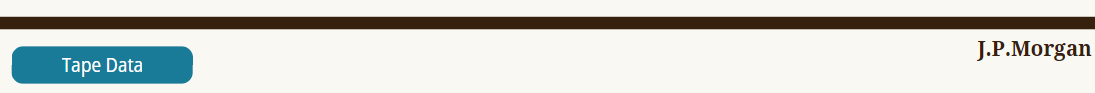

## Contents

- [Load Data](#Load-Data)<br>
- [Data Cleaning](#Data-Cleaning)<br>
- [Transform Data](#Transform-Data)<br>
- [Features](#Features)<br>
- [EDA](#EDA)<br>

## Load Data

__Sharepoint Data Location:__ https://uob-my.sharepoint.com/personal/ln19592_bristol_ac_uk/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fln19592%5Fbristol%5Fac%5Fuk%2FDocuments%2FTeaching%2FDS%20Mini%20Project%2FDSMP%202023%2D24%2FProblems%2FProblem%20B%20data&ga=1

__Data Description:__
- 125 csv, 3 columns
- Cols- Time, Price, Quantity

In [1]:
#import required libraries
import os
import pandas as pd
from datetime import datetime

In [2]:
#load data
path = 'C:/Users/s_sta/OneDrive/Desktop/DSMP/Tapes'
all_files = os.listdir(path)

#initialise empty df append all data
tape = pd.DataFrame()

In [3]:
#loop through each file in the directory
for file in all_files:
    if file.endswith('.csv'):
        #extract date from filename 
        date = file.split('_')[2].split('t')[0]

        #load csv file
        df = pd.read_csv(f'{path}/{file}')

        #add date col
        df['Date'] = pd.to_datetime(date)

        #set col names
        df.columns = ['Time', 'Price', 'Quantity', 'Date']

        #concatenate
        tape = pd.concat([tape, df], ignore_index=True)

In [4]:
tape.shape

(3340376, 4)

In [5]:
tape.head()

,Time,Price,Quantity,Date
0,11.067,269,1,2025-01-02
1,11.222,267,2,2025-01-02
2,12.338,270,2,2025-01-02
3,13.733,267,3,2025-01-02
4,18.321,265,2,2025-01-02


In [8]:
#save tape (in Jupyter env)
tape.to_csv('tape.csv', index=False)

- [Return to contents](#Contents)<br>

## Data Cleaning

__Missing Values__

In [9]:
#check for missing values
missing_values = tape.isnull().sum()

print("Missing Values:\n", missing_values)

Missing Values:
 Time        0
Price       0
Quantity    0
Date        0
dtype: int64


__Duplicate Rows__

In [10]:
#check for duplicate rows
duplicate_rows = tape.duplicated().sum()

print("Duplicate Rows:", duplicate_rows)

Duplicate Rows: 59827


In [ ]:
#print("Shape before removing duplicates:", tape.shape)

In [ ]:
#remove duplicate rows
#tape.drop_duplicates(inplace=True)

In [ ]:
#print("Shape after removing duplicates:", tape.shape)

__Data Types__

In [11]:
#Do we need to change data types?
tape.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3340376 entries, 0 to 3340375
Data columns (total 4 columns):
 #   Column    Dtype         
---  ------    -----         
 0   Time      float64       
 1   Price     int64         
 2   Quantity  int64         
 3   Date      datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 101.9 MB


In [12]:
#save clean tape (in Jupyter env)
tape.to_csv('tape.csv', index=False)

- [Return to contents](#Contents)<br>

## Transform Data

In [13]:
#import required libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [14]:
#normalise- scaling data to range between 0 and 1
scaler = MinMaxScaler()
tape['Normalised_Price'] = scaler.fit_transform(tape[['Price']])

In [15]:
#standardise- scaling data to mean of 0 and standard deviation of 1)
scaler = StandardScaler()
tape['Standardised_Price'] = scaler.fit_transform(tape[['Price']])

In [16]:
tape.head()

,Time,Price,Quantity,Date,Normalised_Price,Standardised_Price
0,11.067,269,1,2025-01-02,0.578947,0.855046
1,11.222,267,2,2025-01-02,0.572368,0.830077
2,12.338,270,2,2025-01-02,0.582237,0.867531
3,13.733,267,3,2025-01-02,0.572368,0.830077
4,18.321,265,2,2025-01-02,0.565789,0.805109


In [17]:
#save transformed tape (in Jupyter env)
tape.to_csv('tape.csv', index=False)

- [Return to contents](#Contents)<br>

## Features

(using raw Price)

__Technical Indicators__<br>
To reveal trends, momentum, and volatility.

In [18]:
#import required libraries
import numpy as np

In [19]:
#moving average
tape['Moving_Average_10'] = tape['Price'].rolling(window=10).mean()  #10 period moving average

In [20]:
#bollinger bands
MA = tape['Price'].rolling(window=20).mean()
SD = tape['Price'].rolling(window=20).std()

tape['Upper_BB'] = MA + (2 * SD)  #upper bollinger band
tape['Lower_BB'] = MA - (2 * SD)  #lower bollinger band

In [52]:
tape['Middle_BB'] = tape['Price'].rolling(window=20).mean()#middle bb

In [21]:
#macd
EMA_12 = tape['Price'].ewm(span=12, adjust=False).mean()
EMA_26 = tape['Price'].ewm(span=26, adjust=False).mean()

tape['MACD'] = EMA_12 - EMA_26
tape['Signal_Line'] = tape['MACD'].ewm(span=9, adjust=False).mean()

In [22]:
#relative strength index
delta = tape['Price'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
RS = gain / loss

tape['RSI'] = 100 - (100 / (1 + RS))

__Lag Features__<br>
To capture time based patterns and dependencies.

In [23]:
#lag price
tape['Lagged_Price'] = tape['Price'].shift(1)  #previous day price

In [24]:
#lag volume
tape['Lagged_Volume'] = tape['Quantity'].shift(1)  #previous day volume

__Window Statistics__<br> 
To helps in understanding local trends and volatility.

In [25]:
#Rolling 7
tape['Rolling_Mean_7'] = tape['Price'].rolling(window=7).mean()

tape['Rolling_Median_7'] = tape['Price'].rolling(window=7).median()

tape['Rolling_Std_7'] = tape['Price'].rolling(window=7).std()

__Time Features__<br>
To identify seasonal patterns or time based trends.

In [26]:
tape['Year'] = tape['Date'].dt.year
tape['Month'] = tape['Date'].dt.month
tape['Week'] = tape['Date'].dt.isocalendar().week
tape['Day'] = tape['Date'].dt.day
tape['DayOfWeek'] = tape['Date'].dt.dayofweek

__Volume-Weighted Average Price__<br> 
A trading benchmark that gives an average price a security has traded at throughout the day, based on both volume and price.

In [27]:
tape['VWAP'] = (tape['Price'] * tape['Quantity']).cumsum() / tape['Quantity'].cumsum()

__Rate of Change__<br>
Measurement of the percentage change in price over a specified time period and can provide insight into the momentum of the stock.

In [28]:
tape['Rate_of_Change'] = tape['Price'].pct_change(periods=1)  #change from previous day

__Fourier Transforms__<br>
To identify long term cycles and trends.

In [29]:
FFT = np.fft.fft(np.asarray(tape['Price'].tolist()))
FFT_real = np.real(FFT)
tape['FFT'] = FFT_real

In [30]:
#save tape with features (in Jupyter env)
tape.to_csv('tape.csv', index=False)

In [ ]:
#Are candlestick patterns appropriate? ta library offers a variety we could explore

- [Return to contents](#Contents)<br>

## EDA

In [54]:
#import required libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "notebook"

__Bollinger Bands__<br>
_Further Reading:_ https://www.investopedia.com/terms/b/bollingerbands.asp, https://towardsdev.com/python-trading-guide-bollinger-bands-111ccc318bdc

- Bollinger Bands® is a technical analysis tool to generate oversold or overbought signals and was developed by John Bollinger.
- Three lines compose Bollinger Bands: A simple moving average, or the middle band, and an upper and lower band.
- The upper and lower bands are typically 2 standard deviations +/- from a 20-day simple moving average and can be modified.
- When the price continually touches the upper Bollinger Band, it can indicate an overbought signal.
- If the price continually touches the lower band it can indicate an oversold signal.

Example visualisation: 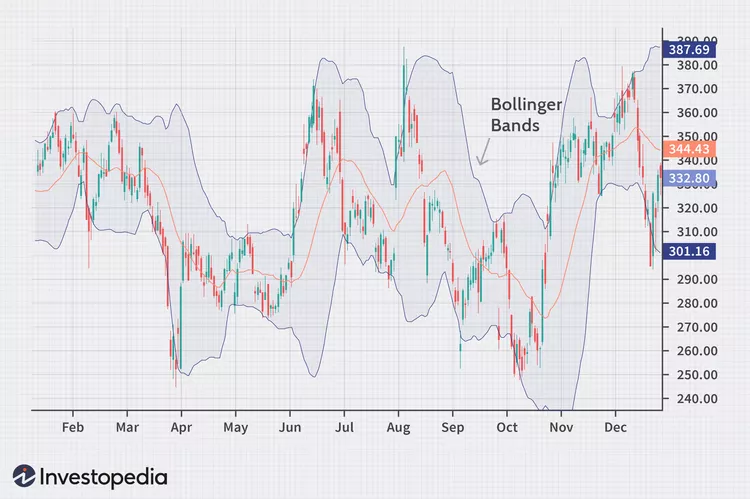

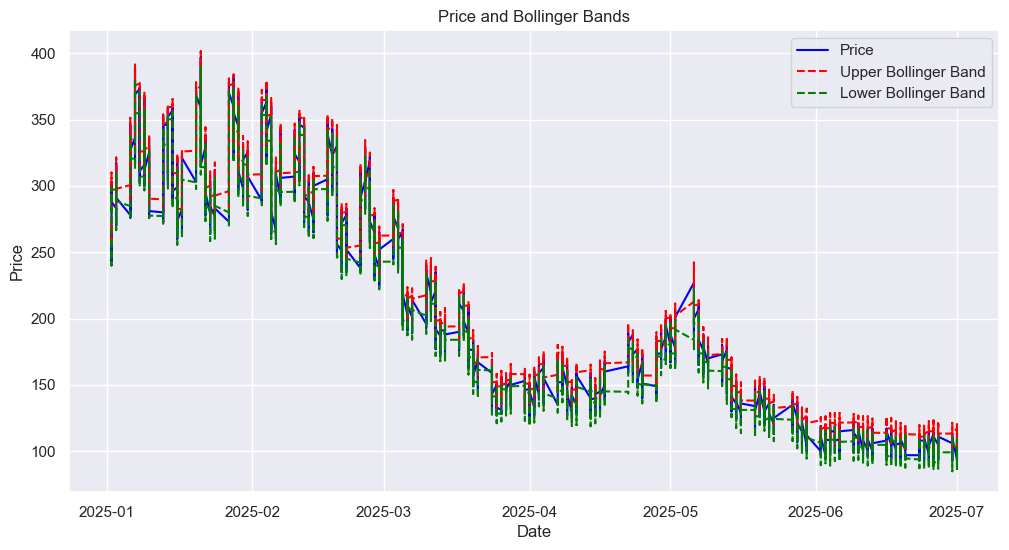

In [47]:
#set style & size
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

#olot price
plt.plot(tape['Date'], tape['Price'], label='Price', color='blue')

#plot bollinger bands
plt.plot(tape['Date'], tape['Upper_BB'], label='Upper Bollinger Band', linestyle='--', color='red')

plt.plot(tape['Date'], tape['Lower_BB'], label='Lower Bollinger Band', linestyle='--', color='green')

#labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price and Bollinger Bands')
plt.legend()

plt.show()

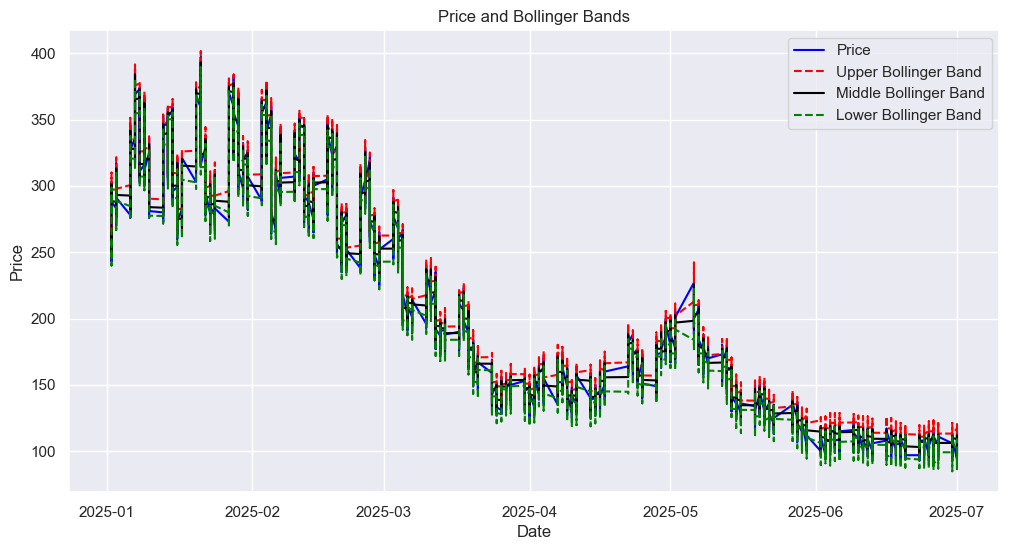

In [56]:
#set style & size
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

#olot price
plt.plot(tape['Date'], tape['Price'], label='Price', color='blue')

#plot bollinger bands
plt.plot(tape['Date'], tape['Upper_BB'], label='Upper Bollinger Band', linestyle='--', color='red')
plt.plot(tape['Date'], tape['Middle_BB'], label='Middle Bollinger Band', color='black')
plt.plot(tape['Date'], tape['Lower_BB'], label='Lower Bollinger Band', linestyle='--', color='green')

#labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price and Bollinger Bands')
plt.legend()

plt.show()

In [2]:
#can I make an interactive version?
#use plotly
#fig = go.Figure()

#price
#fig.add_trace(go.Scatter(x=tape['Date'], y=tape['Price'], mode='lines', name='Price'))

#upper and lower bb
#fig.add_trace(go.Scatter(x=tape['Date'], y=tape['Upper_BB'], mode='lines', name='Upper Bollinger Band',
                         #line=dict(color='red')))
#fig.add_trace(go.Scatter(x=tape['Date'], y=tape['Lower_BB'], fill='tonexty', mode='lines', name='Lower Bollinger Band',
                         #line=dict(color='green')))

#middle bb
#fig.add_trace(go.Scatter(x=tape['Date'], y=tape['Middle_BB'], mode='lines', name='Middle Bollinger Band',
                         #line=dict(color='blue')))

#fig.update_layout(title='Stock Price with Bollinger Bands',
                  #xaxis_title='Date',
                  #yaxis_title='Price',
                  #showlegend=True)
                  #xaxis=dict( #date slider (was taking really long to visualise -will revisit)
                      #rangeselector=dict(
                          #buttons=list([
                              #dict(count=1, label="1M", step="month", stepmode="backward"),
                              #dict(count=6, label="6M", step="month", stepmode="backward"),
                              #dict(count=1, label="YTD", step="year", stepmode="todate"),
                              #dict(count=1, label="1Y", step="year", stepmode="backward"),
                              #dict(step="all")
                          #])
                      #),
                      #rangeslider=dict(
                          #visible=True
                      #),
                      #type="date"
                  #))

#fig.show()

- [Return to contents](#Contents)<br>